In [2]:
import torch
import torch.nn as nn
from datasets import load_dataset
from collections import Counter
from torch.utils.data import DataLoader, Dataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/adan.mora/Desktop/code/university/deep-learning-and-big-data-course/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split='validation')
train_texts = dataset["text"]

In [32]:
train_texts

Column(['', ' = Homarus gammarus = \n', '', ' Homarus gammarus , known as the European lobster or common lobster , is a species of clawed lobster from the eastern Atlantic Ocean , Mediterranean Sea and parts of the Black Sea . It is closely related to the American lobster , H. americanus . It may grow to a length of 60 cm ( 24 in ) and a mass of 6 kilograms ( 13 lb ) , and bears a conspicuous pair of claws . In life , the lobsters are blue , only becoming " lobster red " on cooking . Mating occurs in the summer , producing eggs which are carried by the females for up to a year before hatching into planktonic larvae . Homarus gammarus is a highly esteemed food , and is widely caught using lobster pots , mostly around the British Isles . \n', ''])

In [33]:
from itertools import chain

def tokenize(text):
    return text.lower().split()

tokens = [tokenize(line) for line in train_texts if line.strip()]
flat_tokens = list(chain.from_iterable(tokens))
vocab_counter = Counter(flat_tokens)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(vocab_counter.items())}
vocab["<pad>"] = 0
vocab["<unk>"] = 1
inv_vocab = {idx: word for word, idx in vocab.items()}

In [34]:
len(inv_vocab)

17601

In [35]:
inv_vocab

{2: '=',
 3: 'homarus',
 4: 'gammarus',
 5: ',',
 6: 'known',
 7: 'as',
 8: 'the',
 9: 'european',
 10: 'lobster',
 11: 'or',
 12: 'common',
 13: 'is',
 14: 'a',
 15: 'species',
 16: 'of',
 17: 'clawed',
 18: 'from',
 19: 'eastern',
 20: 'atlantic',
 21: 'ocean',
 22: 'mediterranean',
 23: 'sea',
 24: 'and',
 25: 'parts',
 26: 'black',
 27: '.',
 28: 'it',
 29: 'closely',
 30: 'related',
 31: 'to',
 32: 'american',
 33: 'h.',
 34: 'americanus',
 35: 'may',
 36: 'grow',
 37: 'length',
 38: '60',
 39: 'cm',
 40: '(',
 41: '24',
 42: 'in',
 43: ')',
 44: 'mass',
 45: '6',
 46: 'kilograms',
 47: '13',
 48: 'lb',
 49: 'bears',
 50: 'conspicuous',
 51: 'pair',
 52: 'claws',
 53: 'life',
 54: 'lobsters',
 55: 'are',
 56: 'blue',
 57: 'only',
 58: 'becoming',
 59: '"',
 60: 'red',
 61: 'on',
 62: 'cooking',
 63: 'mating',
 64: 'occurs',
 65: 'summer',
 66: 'producing',
 67: 'eggs',
 68: 'which',
 69: 'carried',
 70: 'by',
 71: 'females',
 72: 'for',
 73: 'up',
 74: 'year',
 75: 'before',
 76: 

In [36]:
def encode(tokens):
    return [vocab.get(token, vocab["<unk>"]) for token in tokens]

sequence_length = 30

class LanguageModelDataset(Dataset):
    def __init__(self, lines, seq_len):
        self.data = []
        for line in lines:
            tokens = tokenize(line)
            ids = encode(tokens)
            for i in range(len(ids) - seq_len):
                input_seq = ids[i:i+seq_len]
                target = ids[i+1:i+seq_len+1]
                self.data.append((torch.tensor(input_seq), torch.tensor(target)))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = LanguageModelDataset(train_texts, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [47]:
secuencia = next(iter(train_loader))

In [48]:
secuencia[0].size()

torch.Size([32, 30])

In [56]:
secuencia[1].size()

torch.Size([32, 30])

In [57]:
secuencia[0][0]

tensor([13097,    27,    28,   148,  1248,    42, 12853,  4546,    40,  6819,
           43,    72,     8, 12856,     5, 12853,  3467,    40,  2254,    43,
           72,     8, 12855, 13098,    24, 13099,     5, 12853, 13081,  2872])

In [58]:
secuencia[1][0]

tensor([   27,    28,   148,  1248,    42, 12853,  4546,    40,  6819,    43,
           72,     8, 12856,     5, 12853,  3467,    40,  2254,    43,    72,
            8, 12855, 13098,    24, 13099,     5, 12853, 13081,  2872,    40])

In [50]:
s = secuencia[0][0].numpy().tolist()
[inv_vocab[i] for i in s if i in inv_vocab]

['computers',
 '.',
 'it',
 'has',
 'appeared',
 'in',
 'sonic',
 'compilation',
 '(',
 '1995',
 ')',
 'for',
 'the',
 'genesis',
 ',',
 'sonic',
 'jam',
 '(',
 '1997',
 ')',
 'for',
 'the',
 'sega',
 'saturn',
 'and',
 'game.com',
 ',',
 'sonic',
 'mega',
 'collection']

In [51]:
secuencia_str = ' '.join([inv_vocab[i] for i in s if i in inv_vocab])
secuencia_str

'computers . it has appeared in sonic compilation ( 1995 ) for the genesis , sonic jam ( 1997 ) for the sega saturn and game.com , sonic mega collection'

In [52]:
from transformers import AutoTokenizer

# Load pretrained tokenizer (BERT example)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

encoding = tokenizer(secuencia_str, return_tensors="pt")  # returns PyTorch tensors

print("Tokenized text:", tokenizer.tokenize(secuencia_str))
print("Token IDs:", encoding["input_ids"])
print("Attention mask:", encoding["attention_mask"])

Tokenized text: ['computers', '.', 'it', 'has', 'appeared', 'in', 'sonic', 'compilation', '(', '1995', ')', 'for', 'the', 'genesis', ',', 'sonic', 'jam', '(', '1997', ')', 'for', 'the', 'sega', 'saturn', 'and', 'game', '.', 'com', ',', 'sonic', 'mega', 'collection']
Token IDs: tensor([[  101,  7588,  1012,  2009,  2038,  2596,  1999, 12728,  6268,  1006,
          2786,  1007,  2005,  1996, 11046,  1010, 12728,  9389,  1006,  2722,
          1007,  2005,  1996, 16562, 14784,  1998,  2208,  1012,  4012,  1010,
         12728, 13164,  3074,   102]])
Attention mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


# RNNs Recurrent Neural Networks


* Secuencias: series de tiempo, texto

![Sample Image](./images/rnn2.jpeg)

![Sample Image](./images/rnns.jpeg)

In [53]:
class RNNLM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embed(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size).to(DEVICE)


In [59]:
next(iter(train_dataset))

(tensor([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 10,  5, 13, 14, 15, 16, 17, 10,
         18,  8, 19, 20, 21,  5, 22, 23, 24, 25, 16,  8]),
 tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 10,  5, 13, 14, 15, 16, 17, 10, 18,
          8, 19, 20, 21,  5, 22, 23, 24, 25, 16,  8, 26]))

In [60]:
vocab_size = len(vocab)
embed_size = 64
hidden_size = 128
epochs = 10

In [61]:
model = RNNLM(vocab_size, embed_size, hidden_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        hidden = model.init_hidden(inputs.size(0))
        optimizer.zero_grad()
        output, hidden = model(inputs, hidden)
        loss = criterion(output.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")

Epoch 1, Loss: 24200.61
Epoch 2, Loss: 14645.70
Epoch 3, Loss: 11250.27
Epoch 4, Loss: 9600.56
Epoch 5, Loss: 8647.84


KeyboardInterrupt: 

# Qué pasa adentro de la RNN?

``` python
sequence = [x₁, x₂, x₃, ..., xₜ]  # xᵢ is a vector for each word

h₀ = 0                       # initial hidden state (often zeros)
h₁ = tanh(Wₓx₁ + Wₕh₀ + b)   ← step 1
h₂ = tanh(Wₓx₂ + Wₕh₁ + b)   ← step 2
h₃ = tanh(Wₓx₃ + Wₕh₂ + b)   ← step 3
...
```

In [64]:
def generate_text(model, start_word, max_len=20):
    model.eval()
    input = torch.tensor([[vocab.get(start_word, vocab["<unk>"])]], dtype=torch.long).to(DEVICE)
    hidden = model.init_hidden(1)
    output_words = [start_word]

    with torch.no_grad():
        for _ in range(max_len - 1):
            output, hidden = model(input, hidden)
            pred = output[:, -1, :]
            word_id = torch.argmax(pred, dim=-1).item()
            word = inv_vocab.get(word_id, "<unk>")
            output_words.append(word)
            input = torch.tensor([[word_id]], dtype=torch.long).to(DEVICE)

    return ' '.join(output_words)

In [66]:
generate_text(model, "artificial", 50)

'artificial jane stork flew up supplies in the same period , wzks ( fm 104 @.@ 1 ) , wexr ( fm 106 @.@ 9 ) , wyhl ( am 1450 ) , and wkzb ( fm 95 @.@ 1 ) , wexr ( fm 106 @.@ 9 ) ,'

# LSTM Long-Short Term Memory RNNs

![Sample Image](./images/lstm1.png)

![Sample Image](./images/lstm2.png)

In [67]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.lstm(x)
        return self.fc(out)

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size).to(DEVICE)

In [69]:
vocab_size = len(vocab)
embed_size = 64
hidden_size = 128
epochs = 3

model = LSTM(vocab_size, embed_size, hidden_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")

Epoch 1, Loss: 26877.53


KeyboardInterrupt: 

In [ ]:
generate_text(model, "mountain")

# Transformers

## Attention is all you need 
[link to paper](https://arxiv.org/abs/1706.03762)

![Sample Image](./images/attention1.png)

![Sample Image](./images/attention2.png)

![Sample Image](./images/attention3.png)

![Sample Image](./images/attention-example.png)

## Example with dummy data from scratch

In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0)

# Dummy input: (batch=1, seq_len=4, embed_dim=8)
x = torch.rand(1, 4, 8)
print(x)

# Linear layers to get Q, K, V
embed_dim = 8
q_proj = torch.nn.Linear(embed_dim, embed_dim)
k_proj = torch.nn.Linear(embed_dim, embed_dim)
v_proj = torch.nn.Linear(embed_dim, embed_dim)

Q = q_proj(x)  # (1, 4, 8)
K = k_proj(x)  # (1, 4, 8)
V = v_proj(x)  # (1, 4, 8)

# Attention scores
scores = torch.matmul(Q, K.transpose(-2, -1)) / (embed_dim ** 0.5)  # (1, 4, 4)

# Softmax to get weights
weights = F.softmax(scores, dim=-1)  # (1, 4, 4)

# Final output
output = torch.matmul(weights, V)  # (1, 4, 8)

print("Attention Weights:\n", weights.squeeze())

tensor([[[0.4963, 0.7682, 0.0885, 0.1320, 0.3074, 0.6341, 0.4901, 0.8964],
         [0.4556, 0.6323, 0.3489, 0.4017, 0.0223, 0.1689, 0.2939, 0.5185],
         [0.6977, 0.8000, 0.1610, 0.2823, 0.6816, 0.9152, 0.3971, 0.8742],
         [0.4194, 0.5529, 0.9527, 0.0362, 0.1852, 0.3734, 0.3051, 0.9320]]])
Attention Weights:
 tensor([[0.2474, 0.2407, 0.2605, 0.2515],
        [0.2400, 0.2525, 0.2493, 0.2582],
        [0.2485, 0.2424, 0.2651, 0.2441],
        [0.2413, 0.2474, 0.2495, 0.2618]], grad_fn=<SqueezeBackward0>)


## Example using Pytorch with a sentence

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Words for the example
tokens = ["The", "cat", "sat", "on", "the", "mat"]

# Dummy embeddings (simulate pretrained GloVe for simplicity)
embedding_dim = 16
vocab = {word: torch.randn(embedding_dim) for word in set(tokens)}
embeddings = torch.stack([vocab[word] for word in tokens])  # (seq_len, embed_dim)

# Reshape for MultiheadAttention: (seq_len, batch, embed_dim)
x = embeddings.unsqueeze(1)  # (6, 1, 16)

x

tensor([[[ 1.2211, -0.2618,  0.2361, -1.4445, -0.7550,  0.6819,  0.4260,
           0.4354,  0.4379,  0.4426,  0.2427, -1.3644, -0.0308, -0.3209,
           0.5286, -0.6729]],

        [[ 1.2619, -1.5644, -0.2795,  0.9794,  0.0176,  0.7032, -0.3392,
           0.8878, -0.2290,  0.9644,  0.5096, -1.4538,  1.7773, -0.3682,
           0.3734, -0.1908]],

        [[ 0.4987, -0.5041,  1.2160, -3.4924,  0.1622,  0.1120, -0.1556,
          -0.6192,  0.4812, -1.4959, -0.4198,  0.7905, -0.8639, -0.9395,
          -0.0534, -1.8263]],

        [[ 0.4200, -1.5457,  0.4653,  0.1023,  0.6267,  0.0987, -0.8994,
           1.3927,  0.6402, -1.4665,  1.0703,  0.4337, -1.2138, -0.5592,
           0.4264,  0.8121]],

        [[ 0.5755,  0.4458,  0.7946, -1.2567,  0.1165, -0.0930, -1.2001,
           0.2028, -0.5584,  0.8080, -0.4710,  0.1612,  0.5913,  0.0318,
           0.2928,  0.7549]],

        [[-1.0746, -1.0945, -0.1842, -0.8297,  0.2917,  1.1518,  1.5672,
          -1.0007,  0.5611,  1.2098,  0.70

In [4]:
# Multi-head attention layer
mha = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=4, batch_first=False)

# Apply self-attention (need_weights=True to get attention weights)
output, attn_weights = mha(x, x, x, need_weights=True, average_attn_weights=True)

print("Output shape:", output.shape)
print("Attention weights shape:", attn_weights.shape)
print("Tokens:", tokens)

Output shape: torch.Size([6, 1, 16])
Attention weights shape: torch.Size([1, 6, 6])
Tokens: ['The', 'cat', 'sat', 'on', 'the', 'mat']


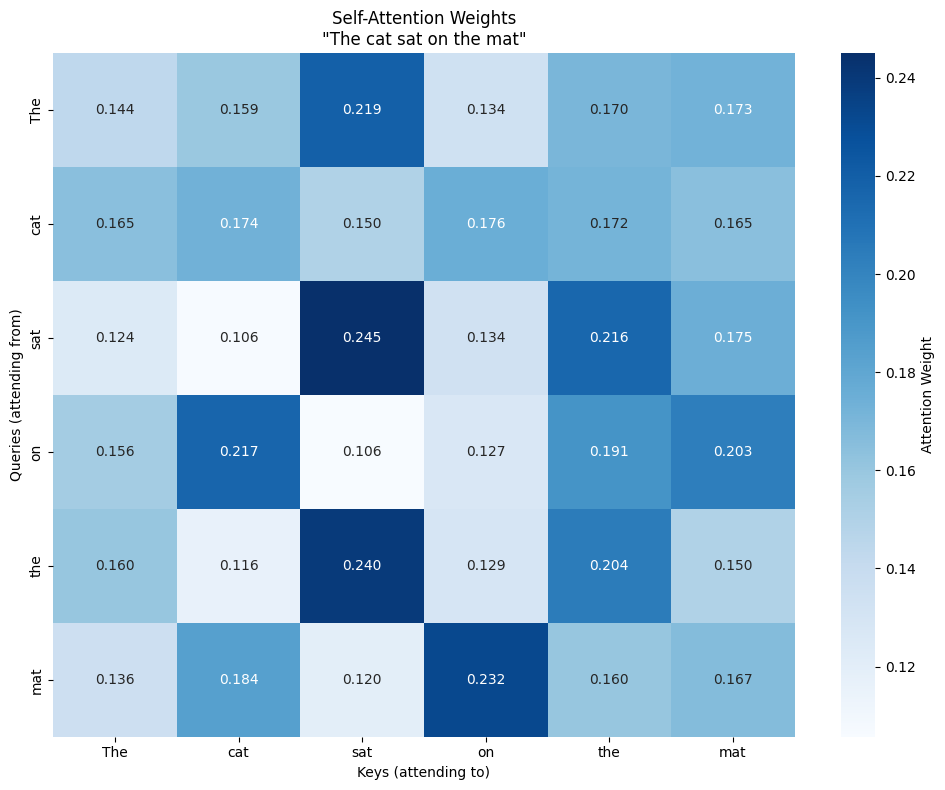


Attention weights matrix:
Rows = Queries (words attending)
Cols = Keys (words being attended to)

Shape: (6, 6)

Interpretation:
- Higher values (darker blue) = stronger attention
- Each row sums to 1.0 (softmax normalization)
- Diagonal shows self-attention (word attending to itself)


In [5]:
# Plot attention weights
plt.figure(figsize=(10, 8))

# Convert attention weights to numpy for plotting
attn_np = attn_weights.squeeze().detach().numpy()

# Create heatmap
sns.heatmap(attn_np, 
            annot=True, 
            fmt='.3f',
            xticklabels=tokens, 
            yticklabels=tokens,
            cmap='Blues',
            cbar_kws={'label': 'Attention Weight'})

plt.title('Self-Attention Weights\n"The cat sat on the mat"')
plt.xlabel('Keys (attending to)')
plt.ylabel('Queries (attending from)')
plt.tight_layout()
plt.show()

print("\nAttention weights matrix:")
print("Rows = Queries (words attending)")
print("Cols = Keys (words being attended to)")
print(f"\nShape: {attn_np.shape}")
print("\nInterpretation:")
print("- Higher values (darker blue) = stronger attention")
print("- Each row sums to 1.0 (softmax normalization)")
print("- Diagonal shows self-attention (word attending to itself)")

# Example using a real Pretrained Bert Model

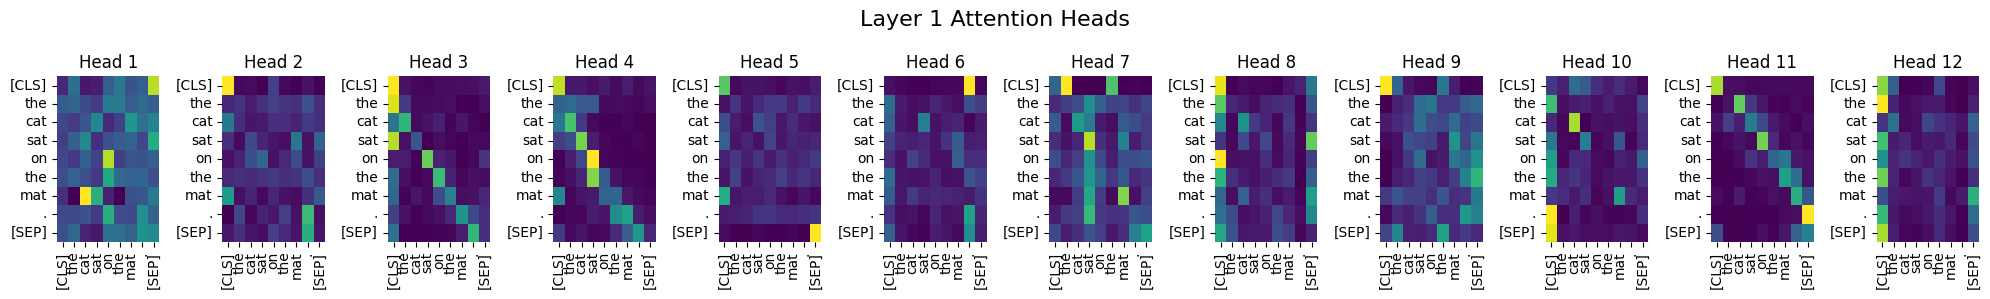

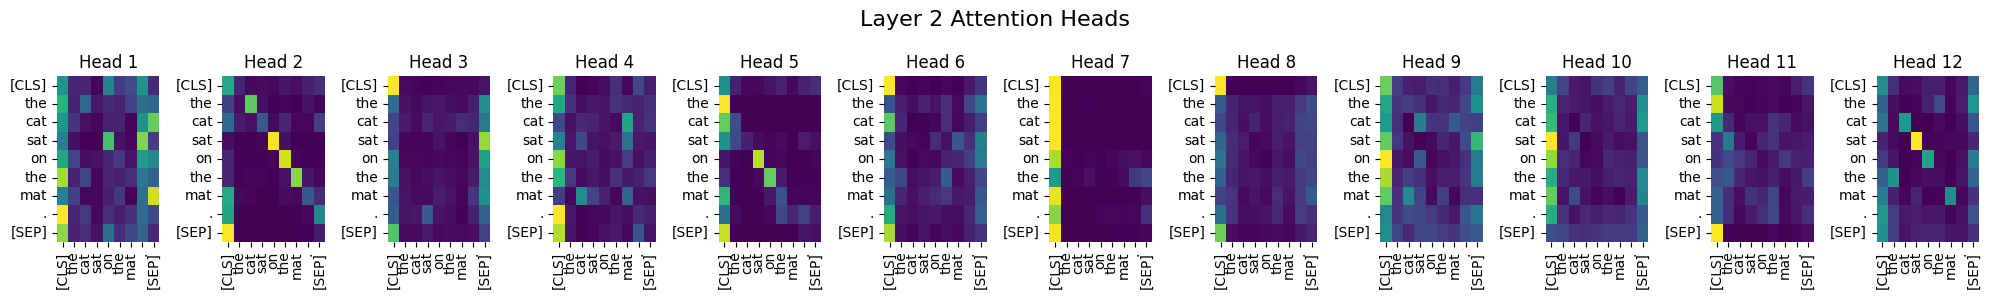

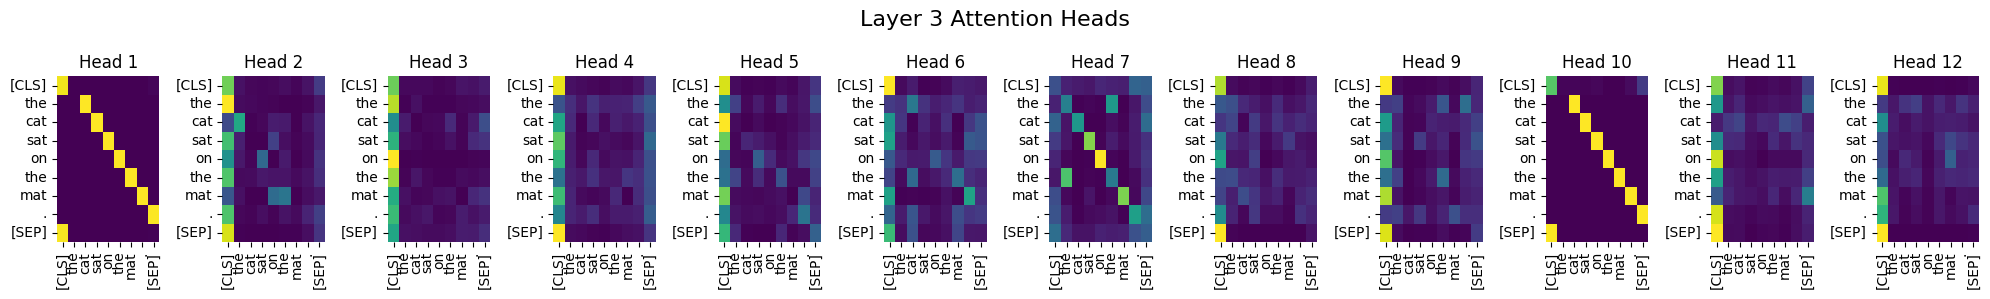

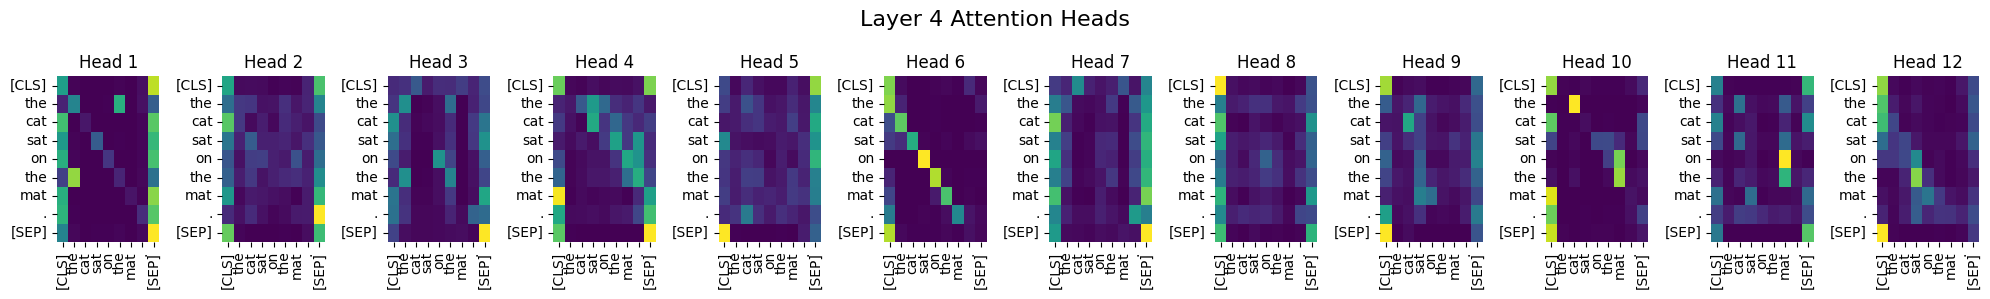

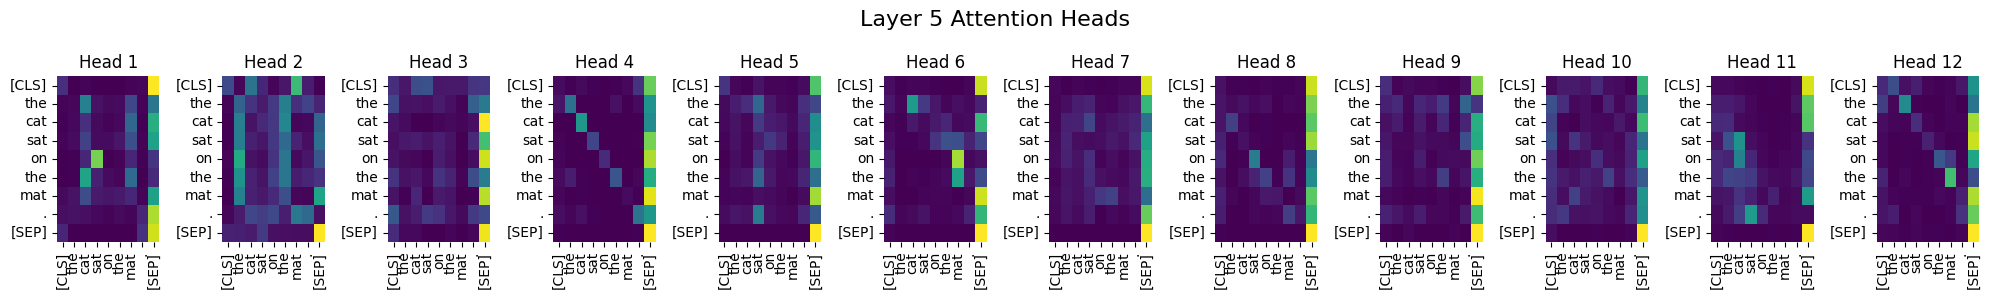

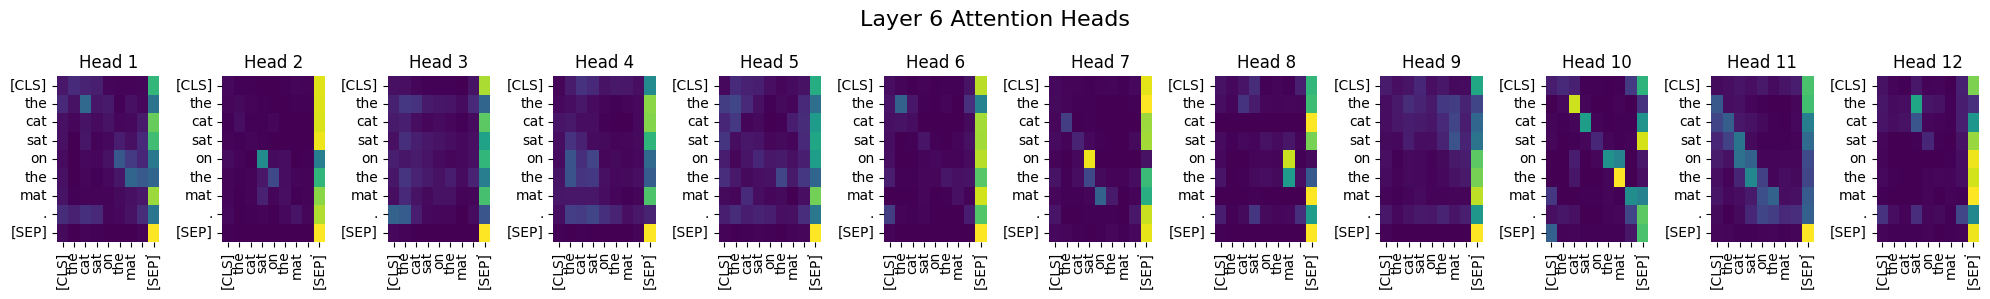

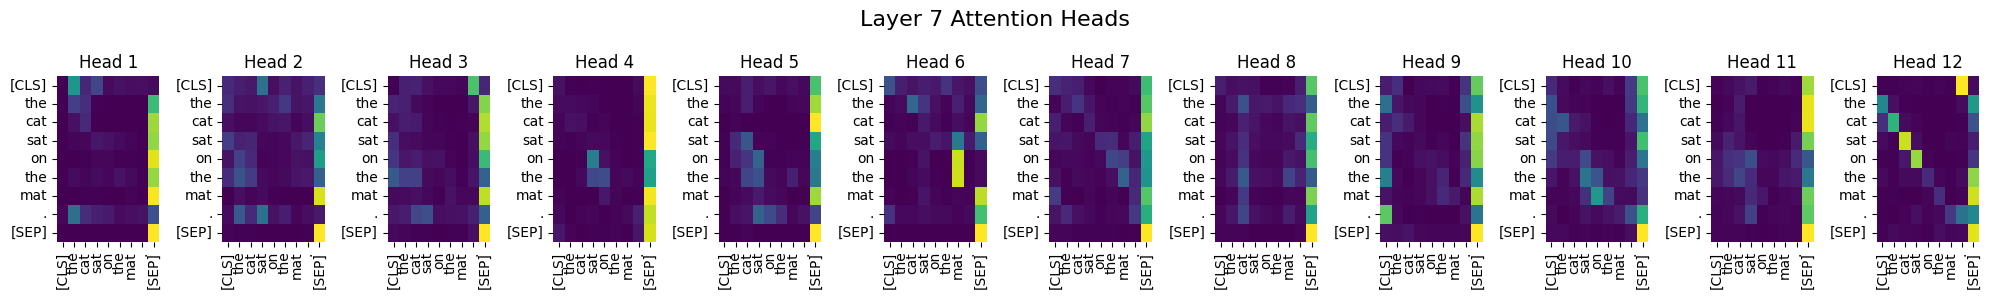

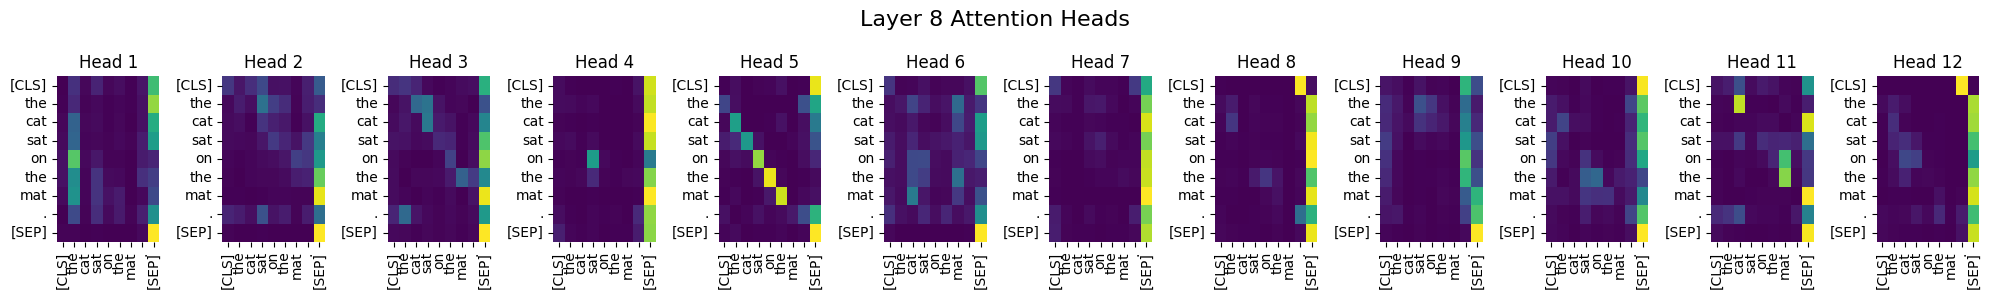

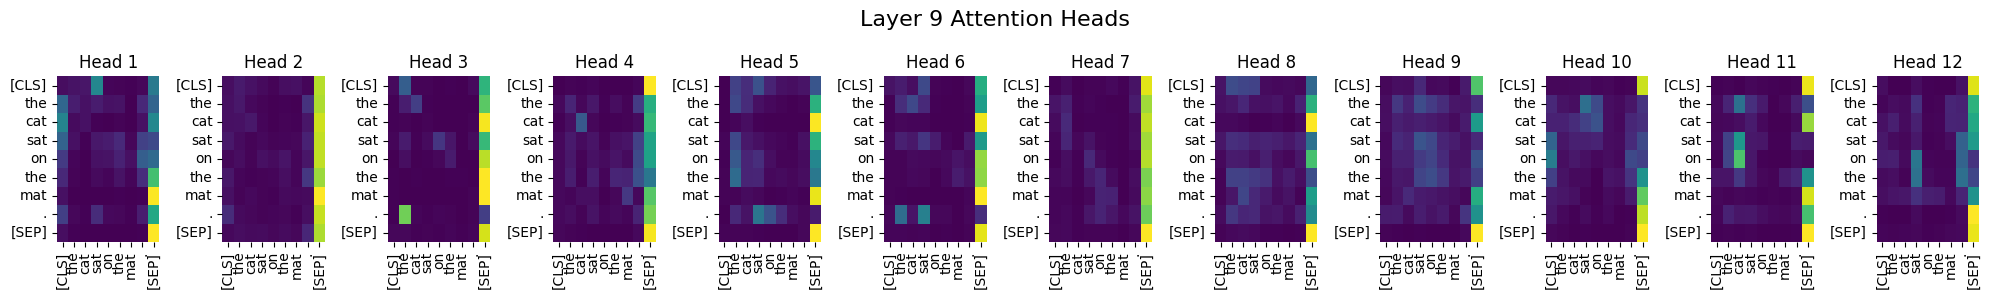

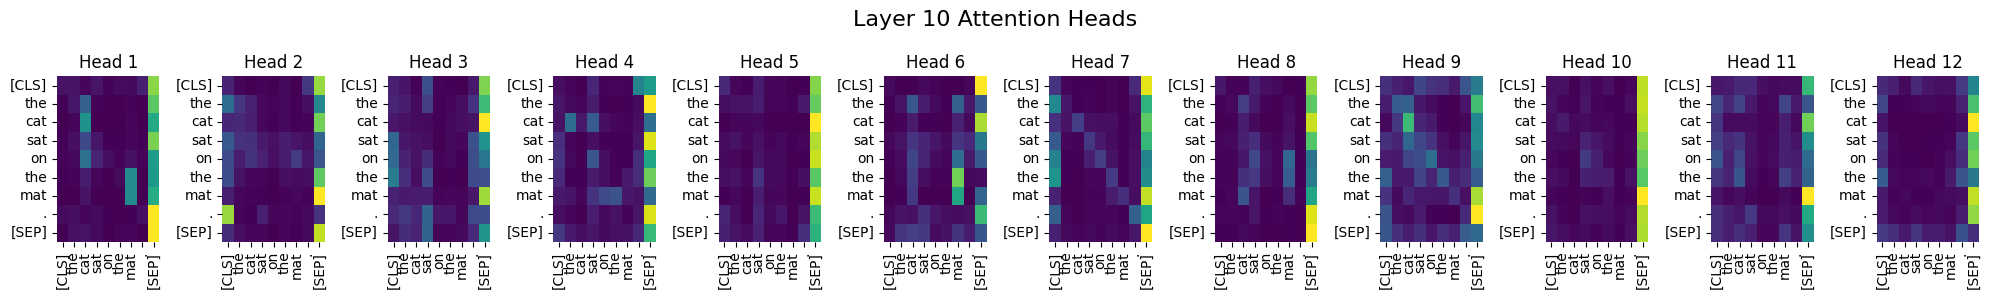

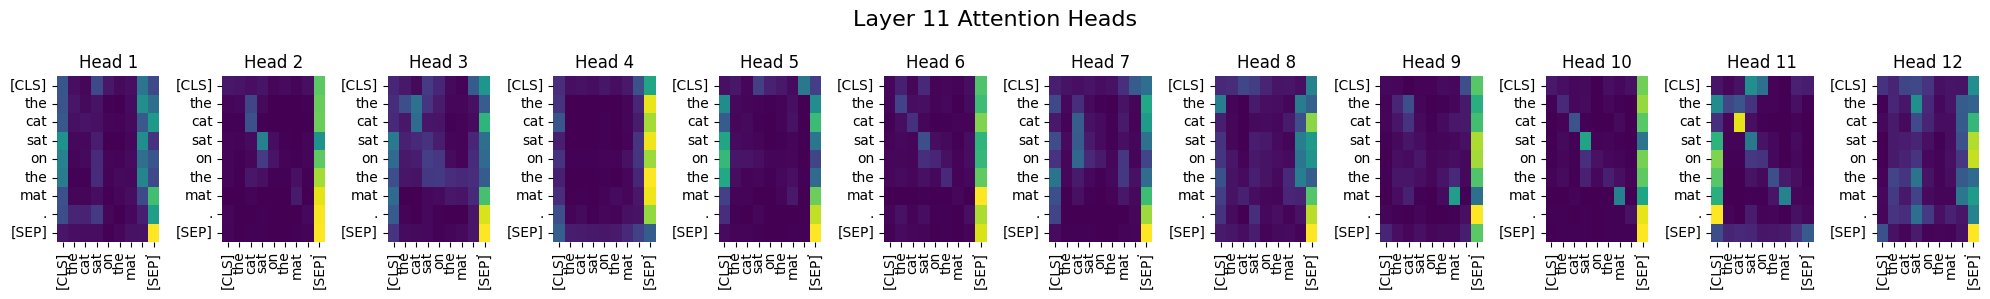

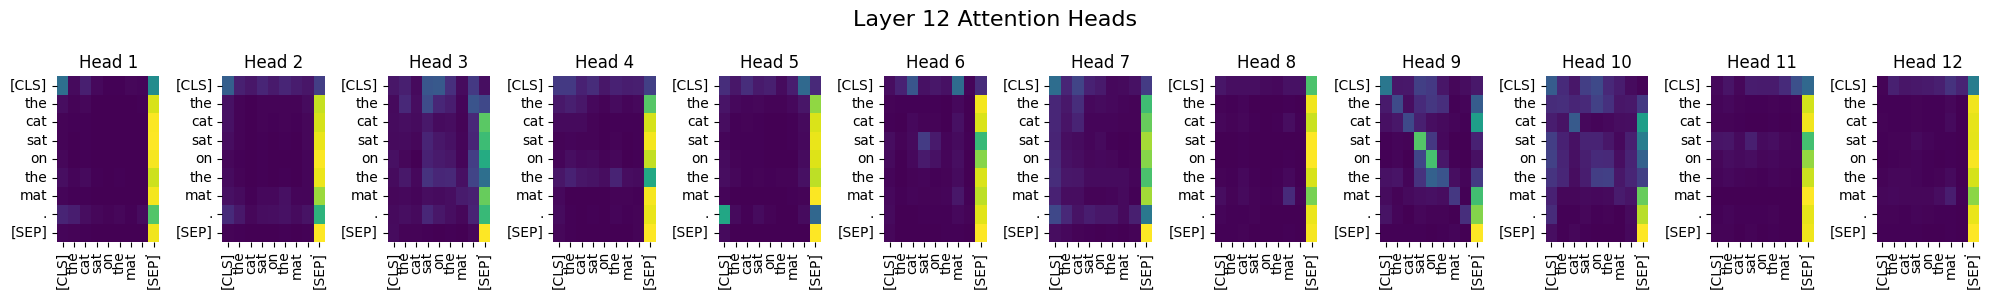

In [22]:
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load pretrained BERT and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)
model.eval()

# 2. Example sentence
sentence = "The cat sat on the mat."

# 3. Tokenize input
inputs = tokenizer(sentence, return_tensors="pt")

# 4. Forward pass (outputs include attentions)
with torch.no_grad():
    outputs = model(**inputs)


attentions = outputs.attentions  # (num_layers, batch, num_heads, seq_len, seq_len)
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
num_layers = len(attentions)
num_heads = attentions[0].shape[1]

# 5. Plot all heads for all layers
for layer in range(num_layers):
    fig, axes = plt.subplots(1, num_heads, figsize=(20, 3))
    fig.suptitle(f"Layer {layer+1} Attention Heads", fontsize=16)
    
    for head in range(num_heads):
        ax = axes[head]
        attn_matrix = attentions[layer][0, head].numpy()  # seq_len x seq_len
        sns.heatmap(attn_matrix,
                    xticklabels=tokens,
                    yticklabels=tokens,
                    cmap="viridis",
                    cbar=False,
                    ax=ax)
        ax.set_title(f"Head {head+1}")
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()


# Project's Model

In [70]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [71]:
def predict_sentiment(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_map = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}
    return [sentiment_map[p] for p in torch.argmax(probabilities, dim=-1).tolist()], probabilities


In [72]:
text = ["I absolutely love the new design of this app!", "The customer service was very disappointing.", "The weather is fine, nothing special. I hate it."]

In [73]:
predicts, props  = predict_sentiment(texts=text)

In [74]:
predicts

['Very Positive', 'Negative', 'Neutral']

In [75]:
props

tensor([[0.0177, 0.0212, 0.0698, 0.2857, 0.6056],
        [0.4311, 0.4863, 0.0444, 0.0185, 0.0197],
        [0.0373, 0.0692, 0.8069, 0.0581, 0.0284]])